In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/dataset/")
!pwd

/content/drive/MyDrive/Colab Notebooks/dataset


In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

#pip install mahotas

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/dataset'
file = os.listdir()
print(file)

['train.csv', 'test.csv', 'train(vaild_label).csv', 'test_image', 'train_image', 'upload_pred3.csv']


In [ ]:
valid_data = pd.read_csv(file[2])
valid_data.head()
# valid=1 validing data , valid=0, training data

,Unnamed: 0,ID,Label,valid
0,0,train_00000.png,0,0
1,1,train_00001.png,1,1
2,2,train_00002.png,1,0
3,3,train_00003.png,5,0
4,4,train_00004.png,5,0


In [ ]:
train_pd = valid_data[(valid_data['valid']==0)]
valid_pd = valid_data[(valid_data['valid']==1)]

In [ ]:
# the numbers of label in training data (training data in validation)
unique, counts = np.unique(train_pd['Label'].values, return_counts=True)
print("unique ", unique)
print("counts: ", counts)

unique  [0 1 2 3 4 5]
counts:  [471 344  70 264 168 450]


In [ ]:
train_pd = train_pd.drop('Unnamed: 0', axis=1)
train_pd = train_pd.drop('valid', axis=1)

valid_pd = valid_pd.drop('Unnamed: 0', axis=1)
valid_pd = valid_pd.drop('valid', axis=1)

In [ ]:
print(train_pd.shape, valid_pd.shape)
print(train_pd.shape[0]/(train_pd.shape[0]+valid_pd.shape[0]))

(1767, 2) (761, 2)
0.6989715189873418


In [ ]:
#adjust weight
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=unique, y=train_pd['Label'].values)
print(class_weights)

[0.62526539 0.85610465 4.20714286 1.1155303  1.75297619 0.65444444]


In [ ]:
train_image_path = os.path.join(path, file[4])

train_pd.reset_index(drop=True, inplace=True)
valid_pd.reset_index(drop=True, inplace=True)

In [ ]:
x_train = []
for i in range(len(train_pd.loc[:,'ID'])):
  image_data = cv2.imread(os.path.join(train_image_path, train_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_train.append(new_image_data)
x_train = np.array(x_train).reshape(-1,512,512,3)

In [ ]:
print(np.array(x_train).shape)

(1767, 512, 512, 3)


In [ ]:
x_valid = []
for i in range(len(valid_pd.loc[:,'ID'])):
  image_data = cv2.imread(os.path.join(train_image_path, valid_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_valid.append(new_image_data)
x_valid = np.array(x_valid).reshape(-1,512,512,3)

In [ ]:
print(np.array(x_valid).shape)

(761, 512, 512, 3)


In [ ]:
y_train = list(train_pd['Label'])
y_valid = list(valid_pd['Label'])

# CNN 4 layer + class weight

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping


import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from matplotlib.pyplot import cm
from tensorflow.keras.models import Model

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

conv_layer4 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pooling_layer3)
pooling_layer4 = MaxPool2D(pool_size=(2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer5 = BatchNormalization()(pooling_layer4)
flatten_layer = Flatten()(pooling_layer5)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                       

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=60, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/60
1413/1413 [==============================] - ETA: 0s - loss: 8.6698 - acc: 0.5796

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 24s 17ms/sample - loss: 8.6698 - acc: 0.5796 - val_loss: 213.8835 - val_acc: 0.1554
Epoch 2/60
1413/1413 [==============================] - 11s 8ms/sample - loss: 1.3500 - acc: 0.7856 - val_loss: 81.6174 - val_acc: 0.1554
Epoch 3/60
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.7163 - acc: 0.8415 - val_loss: 60.1320 - val_acc: 0.3136
Epoch 4/60
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.4769 - acc: 0.8854 - val_loss: 39.8304 - val_acc: 0.3305
Epoch 5/60
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.3565 - acc: 0.9030 - val_loss: 57.9249 - val_acc: 0.3079
Epoch 6/60
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.3858 - acc: 0.8946 - val_loss: 154.5070 - val_acc: 0.2684
Epoch 7/60
1413/1413 [==============================] - 11s 8ms/sample - loss: 0.7517 - acc: 0.8620 - val_loss: 29.9556 - val_acc: 0.4068
Epoch 8/60
1413/1413 [====================

In [ ]:
pred = model.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


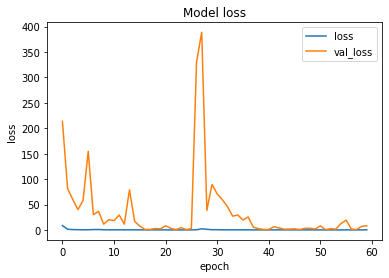

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

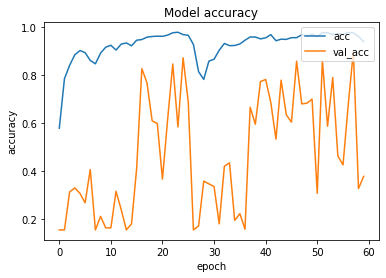

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred = list(np.argmax(pred, axis=1))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

acc=round(accuracy_score(y_valid, valid_pred), 3)
print(acc)

0.378


In [ ]:
cm=confusion_matrix(y_valid, valid_pred)
print(cm)

[[  0   0   0 200   3   0]
 [  0  95   0  52   1   0]
 [  0   0   1  29   0   0]
 [  0   0   0 114   0   0]
 [  0   4   0  33  35   0]
 [  4 106   0  32   9  43]]


In [ ]:
unique_pred, counts_pred = np.unique(valid_pred, return_counts=True)
print("unique ", unique_pred)
print("counts: ", counts_pred)

unique  [0 1 2 3 4 5]
counts:  [  4 205   1 460  48  43]


# CNN 4 layer + class weight / change dim_output

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

conv_layer4 = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(pooling_layer3)
pooling_layer4 = MaxPool2D(pool_size=(2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer5 = BatchNormalization()(pooling_layer4)
flatten_layer = Flatten()(pooling_layer5)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model2 = Model(inputs=input_layer, outputs=output_layer)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 255, 255, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 124, 124, 128)     7385

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model2.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history2 = model2.fit(x=x_train, y=y_train, batch_size=32, epochs=60, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/60
1413/1413 [==============================] - ETA: 0s - loss: 30.6693 - acc: 0.5980

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 45s 32ms/sample - loss: 30.6693 - acc: 0.5980 - val_loss: 2176.4576 - val_acc: 0.1610
Epoch 2/60
1413/1413 [==============================] - 28s 19ms/sample - loss: 9.1650 - acc: 0.7169 - val_loss: 204.5436 - val_acc: 0.2373
Epoch 3/60
1413/1413 [==============================] - 28s 20ms/sample - loss: 5.0810 - acc: 0.8011 - val_loss: 79.2894 - val_acc: 0.1808
Epoch 4/60
1413/1413 [==============================] - 27s 19ms/sample - loss: 2.3361 - acc: 0.7905 - val_loss: 188.5477 - val_acc: 0.3390
Epoch 5/60
1413/1413 [==============================] - 27s 19ms/sample - loss: 1.7092 - acc: 0.8337 - val_loss: 225.5110 - val_acc: 0.3220
Epoch 6/60
1413/1413 [==============================] - 27s 19ms/sample - loss: 1.1128 - acc: 0.8393 - val_loss: 778.8042 - val_acc: 0.2627
Epoch 7/60
1413/1413 [==============================] - 27s 19ms/sample - loss: 0.7792 - acc: 0.8478 - val_loss: 188.9239 - val_acc: 0.2627
Epoch 8/60
1413/1413 [========

In [ ]:
pred2 = model2.predict(x_valid)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


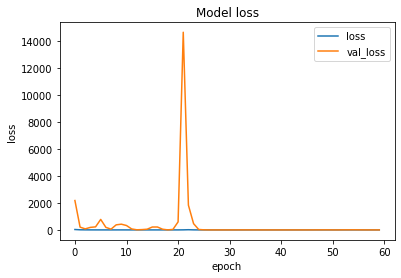

In [ ]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

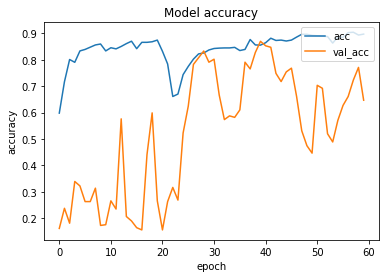

In [ ]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
valid_pred_2 = list(np.argmax(pred2, axis=1))

In [ ]:
acc2=round(accuracy_score(y_valid, valid_pred_2), 4)
print(acc2)

0.6689


In [ ]:
cm2=confusion_matrix(y_valid, valid_pred_2)
print(cm2)

[[ 71   0   0 132   0   0]
 [  1 107   0  38   1   1]
 [  0   0   0  30   0   0]
 [  0   0   0 112   2   0]
 [  0   0   0  11  61   0]
 [ 10  24   0   0   2 158]]


In [ ]:
unique_pred2, counts_pred2 = np.unique(valid_pred_2, return_counts=True)
print("unique ", unique_pred2)
print("counts: ", counts_pred2)

unique  [0 1 3 4 5]
counts:  [ 82 131 323  66 159]


# CNN 3 layer + class wieght / epoch 70

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model3 = Model(inputs=input_layer, outputs=output_layer)
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 255, 255, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 124, 124, 32)      4640

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model3.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history3 = model3.fit(x=x_train, y=y_train, batch_size=32, epochs=70, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/70
1413/1413 [==============================] - ETA: 0s - loss: 22.3184 - acc: 0.6108

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 12s 9ms/sample - loss: 22.3184 - acc: 0.6108 - val_loss: 1362.1418 - val_acc: 0.1723
Epoch 2/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 10.7493 - acc: 0.7679 - val_loss: 297.0741 - val_acc: 0.4181
Epoch 3/70
1413/1413 [==============================] - 12s 8ms/sample - loss: 5.2629 - acc: 0.8330 - val_loss: 102.8996 - val_acc: 0.3164
Epoch 4/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 3.2279 - acc: 0.8825 - val_loss: 172.3591 - val_acc: 0.3814
Epoch 5/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 2.8432 - acc: 0.8896 - val_loss: 521.4867 - val_acc: 0.2627
Epoch 6/70
1413/1413 [==============================] - 11s 8ms/sample - loss: 3.0062 - acc: 0.8769 - val_loss: 143.5552 - val_acc: 0.3136
Epoch 7/70
1413/1413 [==============================] - 13s 9ms/sample - loss: 1.3707 - acc: 0.9193 - val_loss: 280.7081 - val_acc: 0.2881
Epoch 8/70
1413/1413 [=============

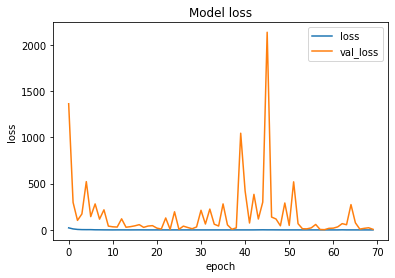

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

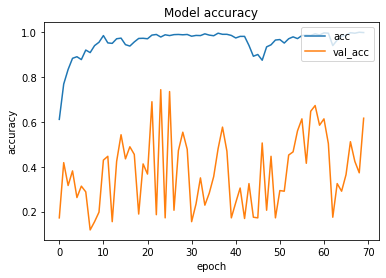

In [ ]:
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
pred3 = model3.predict(x_valid)

In [ ]:
valid_pred_3 = list(np.argmax(pred3, axis=1))

In [ ]:
acc3=round(accuracy_score(y_valid, valid_pred_3), 4)
print(acc3)

0.5887


In [ ]:
cm3=confusion_matrix(y_valid, valid_pred_3)
print(cm3)

[[ 11   7   0 185   0   0]
 [  0 103   0  43   0   2]
 [  0   0   0  30   0   0]
 [  0   3   0 108   3   0]
 [  0   3   0  35  34   0]
 [  0   1   0   1   0 192]]


In [ ]:
unique_pred_3, counts_pred_3 = np.unique(valid_pred_3, return_counts=True)
print("unique ", unique_pred_3)
print("counts: ", counts_pred_3)

unique  [0 1 3 4 5]
counts:  [ 11 117 402  37 194]


# CNN 3 layer + class wieght / epoch 50

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=8, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model4 = Model(inputs=input_layer, outputs=output_layer)
model4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 510, 510, 8)       224       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 255, 255, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 253, 253, 16)      1168      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      4640

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model4.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history4 = model4.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/50
1413/1413 [==============================] - ETA: 0s - loss: 27.6318 - acc: 0.6108

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 12s 8ms/sample - loss: 27.6318 - acc: 0.6108 - val_loss: 340.6513 - val_acc: 0.3757
Epoch 2/50
1413/1413 [==============================] - 13s 9ms/sample - loss: 5.0384 - acc: 0.8344 - val_loss: 204.7579 - val_acc: 0.3785
Epoch 3/50
1413/1413 [==============================] - 12s 9ms/sample - loss: 2.5453 - acc: 0.8924 - val_loss: 235.5890 - val_acc: 0.2627
Epoch 4/50
1413/1413 [==============================] - 12s 8ms/sample - loss: 1.7215 - acc: 0.9130 - val_loss: 140.6309 - val_acc: 0.1751
Epoch 5/50
1413/1413 [==============================] - 12s 9ms/sample - loss: 2.5155 - acc: 0.8861 - val_loss: 154.5123 - val_acc: 0.1610
Epoch 6/50
1413/1413 [==============================] - 12s 8ms/sample - loss: 1.0473 - acc: 0.9115 - val_loss: 163.5099 - val_acc: 0.2627
Epoch 7/50
1413/1413 [==============================] - 12s 8ms/sample - loss: 0.4770 - acc: 0.9505 - val_loss: 76.6875 - val_acc: 0.2797
Epoch 8/50
1413/1413 [================

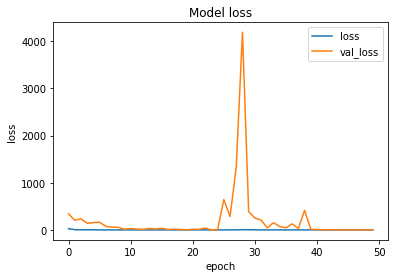

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

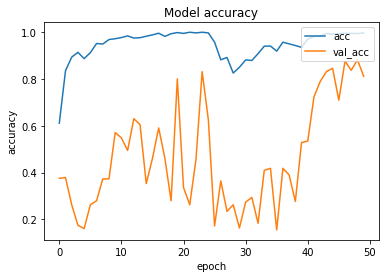

In [ ]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
pred4 = model4.predict(x_valid)

valid_pred_4 = list(np.argmax(pred4, axis=1))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
acc4=round(accuracy_score(y_valid, valid_pred_4), 4)
print(acc4)

0.8252


In [ ]:
cm4=confusion_matrix(y_valid, valid_pred_4)
print(cm4)

[[168   9   3  23   0   0]
 [  3 138   1   3   1   2]
 [  0   0  30   0   0   0]
 [ 36   8   2  65   3   0]
 [  4  10   7  18  33   0]
 [  0   0   0   0   0 194]]


In [ ]:
unique_pred_4, counts_pred_4 = np.unique(valid_pred_4, return_counts=True)
print("unique ", unique_pred_4)
print("counts: ", counts_pred_4)

unique  [0 1 2 3 4 5]
counts:  [211 165  43 109  37 196]


In [ ]:
# create y testing data
test_image_path = os.path.join(path, file[3])
test_pd = pd.read_csv(file[1])
print(test_pd.shape)
test_pd.head()

(10142, 2)


,ID,Label
0,test_00000.png,NaN
1,test_00001.png,NaN
2,test_00002.png,NaN
3,test_00003.png,NaN
4,test_00004.png,NaN


In [ ]:
x_test = []
for i in range(8000,10142):
  image_data = cv2.imread(os.path.join(test_image_path, test_pd["ID"][i]))
  new_image_data = cv2.resize(image_data, dsize=(512, 512))
  x_test.append(new_image_data)
x_test = np.array(x_test).reshape(-1,512,512,3)

In [ ]:
# predict the testing data
test_pred = model4.predict(x_test)
upload_pred = list(np.argmax(test_pred, axis=1))

test_pd['Label'][8000:10142] = upload_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
test_pd['Label'] = test_pd['Label'].astype('int')

In [ ]:
test_pd.to_csv('upload_pred3.csv', index=False)

# CNN 3 layer + class wieght / epoch 50 / change dim_output

In [ ]:
##CNN架構

## input layer
input_layer = Input((512, 512, 3))

## convolutional layers
conv_layer1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_layer)
## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool2D(pool_size=(2, 2))(conv_layer1)

conv_layer2 = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = MaxPool2D(pool_size=(2, 2))(conv_layer2)

conv_layer3 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(pooling_layer2)
pooling_layer3 = MaxPool2D(pool_size=(2, 2))(conv_layer3)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=512, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
output_layer = Dense(units=6, activation='softmax')(dense_layer1)

## define the model with input layer and output layer
model5 = Model(inputs=input_layer, outputs=output_layer)
model5.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                       

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-6)
model5.compile(loss='sparse_categorical_crossentropy',
          optimizer= "adam",
          metrics=['acc'])

In [ ]:
## CNN model fitting
history5 = model5.fit(x=x_train, y=y_train, batch_size=32, epochs=50, validation_split=0.2, class_weight=class_weights)

Train on 1413 samples, validate on 354 samples
Epoch 1/50
1413/1413 [==============================] - ETA: 0s - loss: 105.2014 - acc: 0.5938

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


1413/1413 [==============================] - 43s 30ms/sample - loss: 105.2014 - acc: 0.5938 - val_loss: 5558.2493 - val_acc: 0.1723
Epoch 2/50
1413/1413 [==============================] - 28s 20ms/sample - loss: 42.5916 - acc: 0.7509 - val_loss: 3006.3052 - val_acc: 0.2627
Epoch 3/50
1413/1413 [==============================] - 28s 20ms/sample - loss: 22.4194 - acc: 0.8110 - val_loss: 1984.6688 - val_acc: 0.2627
Epoch 4/50
1413/1413 [==============================] - 28s 20ms/sample - loss: 11.4586 - acc: 0.8351 - val_loss: 895.7468 - val_acc: 0.2881
Epoch 5/50
1413/1413 [==============================] - 28s 20ms/sample - loss: 10.5200 - acc: 0.8344 - val_loss: 1794.3614 - val_acc: 0.2627
Epoch 6/50
1413/1413 [==============================] - 28s 20ms/sample - loss: 4.7767 - acc: 0.8478 - val_loss: 612.3125 - val_acc: 0.3588
Epoch 7/50
1413/1413 [==============================] - 28s 20ms/sample - loss: 2.0517 - acc: 0.8309 - val_loss: 549.7054 - val_acc: 0.2627
Epoch 8/50
1413/1413 

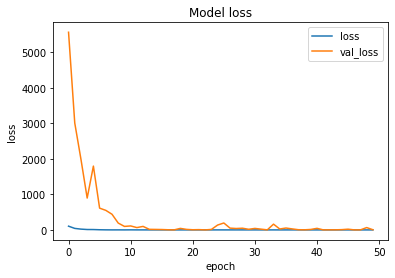

In [ ]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

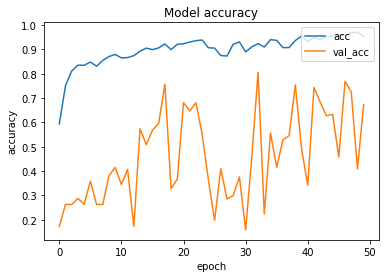

In [ ]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='upper right')
plt.show()

In [ ]:
pred5 = model5.predict(x_valid)

valid_pred_5 = list(np.argmax(pred5, axis=1))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
acc5=round(accuracy_score(y_valid, valid_pred_5), 4)
print(acc5)

0.6662


In [ ]:
cm5=confusion_matrix(y_valid, valid_pred_5)
print(cm5)

[[ 54   1   0 148   0   0]
 [  1 115   0  31   0   1]
 [  0   0   3  27   0   0]
 [  0   0   0 112   2   0]
 [  0   0   0  32  40   0]
 [  4   4   0   3   0 183]]


In [ ]:
unique_pred_5, counts_pred_5 = np.unique(valid_pred_5, return_counts=True)
print("unique ", unique_pred_5)
print("counts: ", counts_pred_5)

unique  [0 1 2 3 4 5]
counts:  [ 59 120   3 353  42 184]
